In [2]:
import numpy as np
import pandas as pd
import chardet

with open('spam.csv', 'rb') as f:
    result = chardet.detect(f.read())
#print(result)

df = pd.read_csv('spam.csv', encoding=result['encoding'])

df.shape
df.sample(10)

# 1. Data cleaning
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df.columns = ['label', 'message']


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

df.duplicated().sum() #check for duplicates in dataframe
df = df.drop_duplicates(keep='first') #drop duplicates

import nltk
#nltk.download('punkt_tab')
#nltk.download('punkt') # Changed from punkt_tab to punkt as punkt_tab is not a valid download identifier
#nltk.download('stopwords') # Download stopwords
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


df['num_characters'] = df['message'].apply(len)
df.info()

df['num_words'] = df['message'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['message'].apply(lambda x:len(nltk.sent_tokenize(x)))

df['message_length'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().str.len()
df['avg_word_length'] = df['message'].str.split().apply(lambda x: np.mean([len(word) for word in x]) if x else 0)
df['capital_ratio'] = df['message'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df['punctuation_count'] = df['message'].str.count(r'[^\w\s]')

df.head()


#spam messages filter
df[df['label'] == 1][['num_characters','num_words','num_sentences','message_length','word_count','avg_word_length','capital_ratio','punctuation_count']].describe()


<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           5169 non-null   int64 
 1   message         5169 non-null   object
 2   num_characters  5169 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 161.5+ KB


,num_characters,num_words,num_sentences,message_length,word_count,avg_word_length,capital_ratio,punctuation_count
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904,137.891271,23.681470,5.000566,0.109991,6.058193
std,30.137753,7.008418,1.488425,30.137753,5.967672,1.046245,0.087543,3.545452
min,13.000000,2.000000,1.000000,13.000000,2.000000,3.333333,0.000000,0.000000
25%,132.000000,25.000000,2.000000,132.000000,22.000000,4.413793,0.052632,3.000000
50%,149.000000,29.000000,3.000000,149.000000,25.000000,4.884615,0.098214,6.000000
75%,157.000000,32.000000,4.000000,157.000000,28.000000,5.391304,0.140625,8.000000
max,224.000000,46.000000,9.000000,224.000000,35.000000,17.333333,0.785276,26.000000


<Axes: >

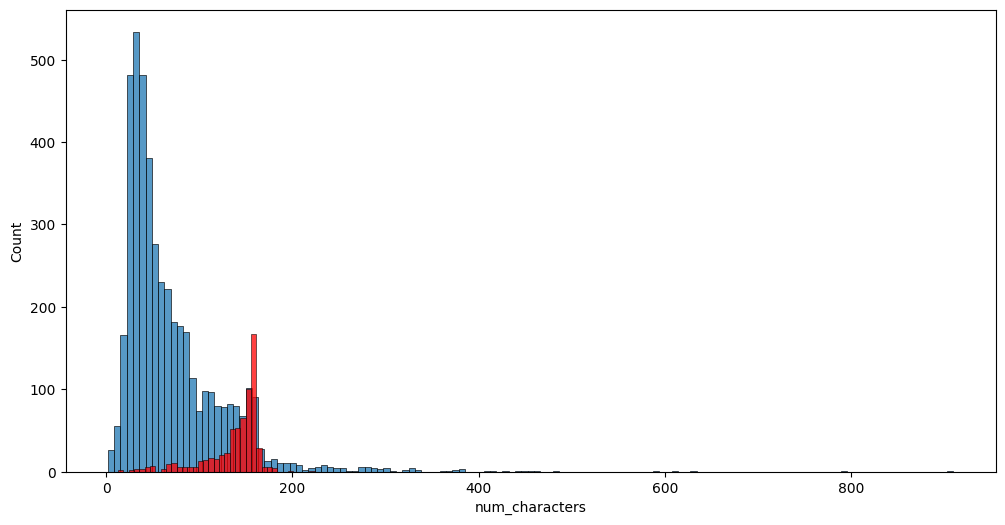

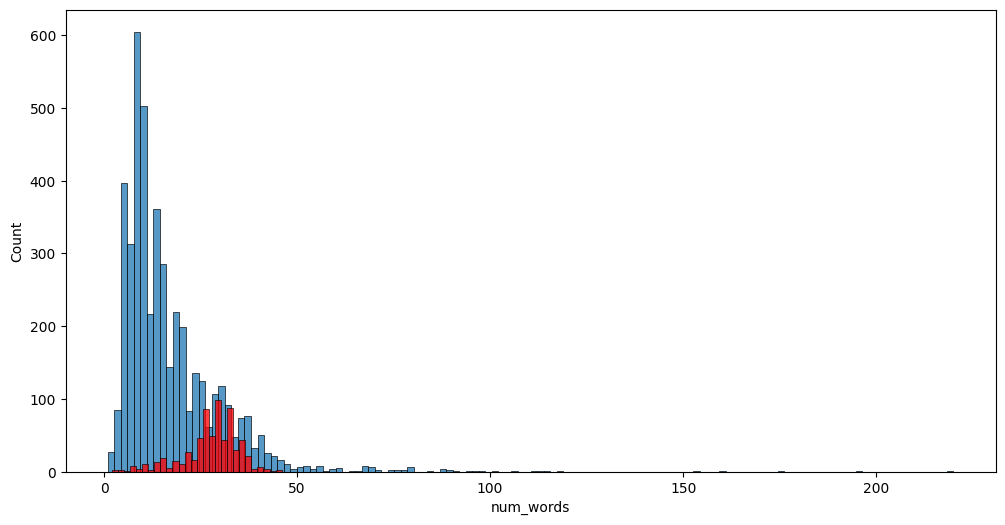

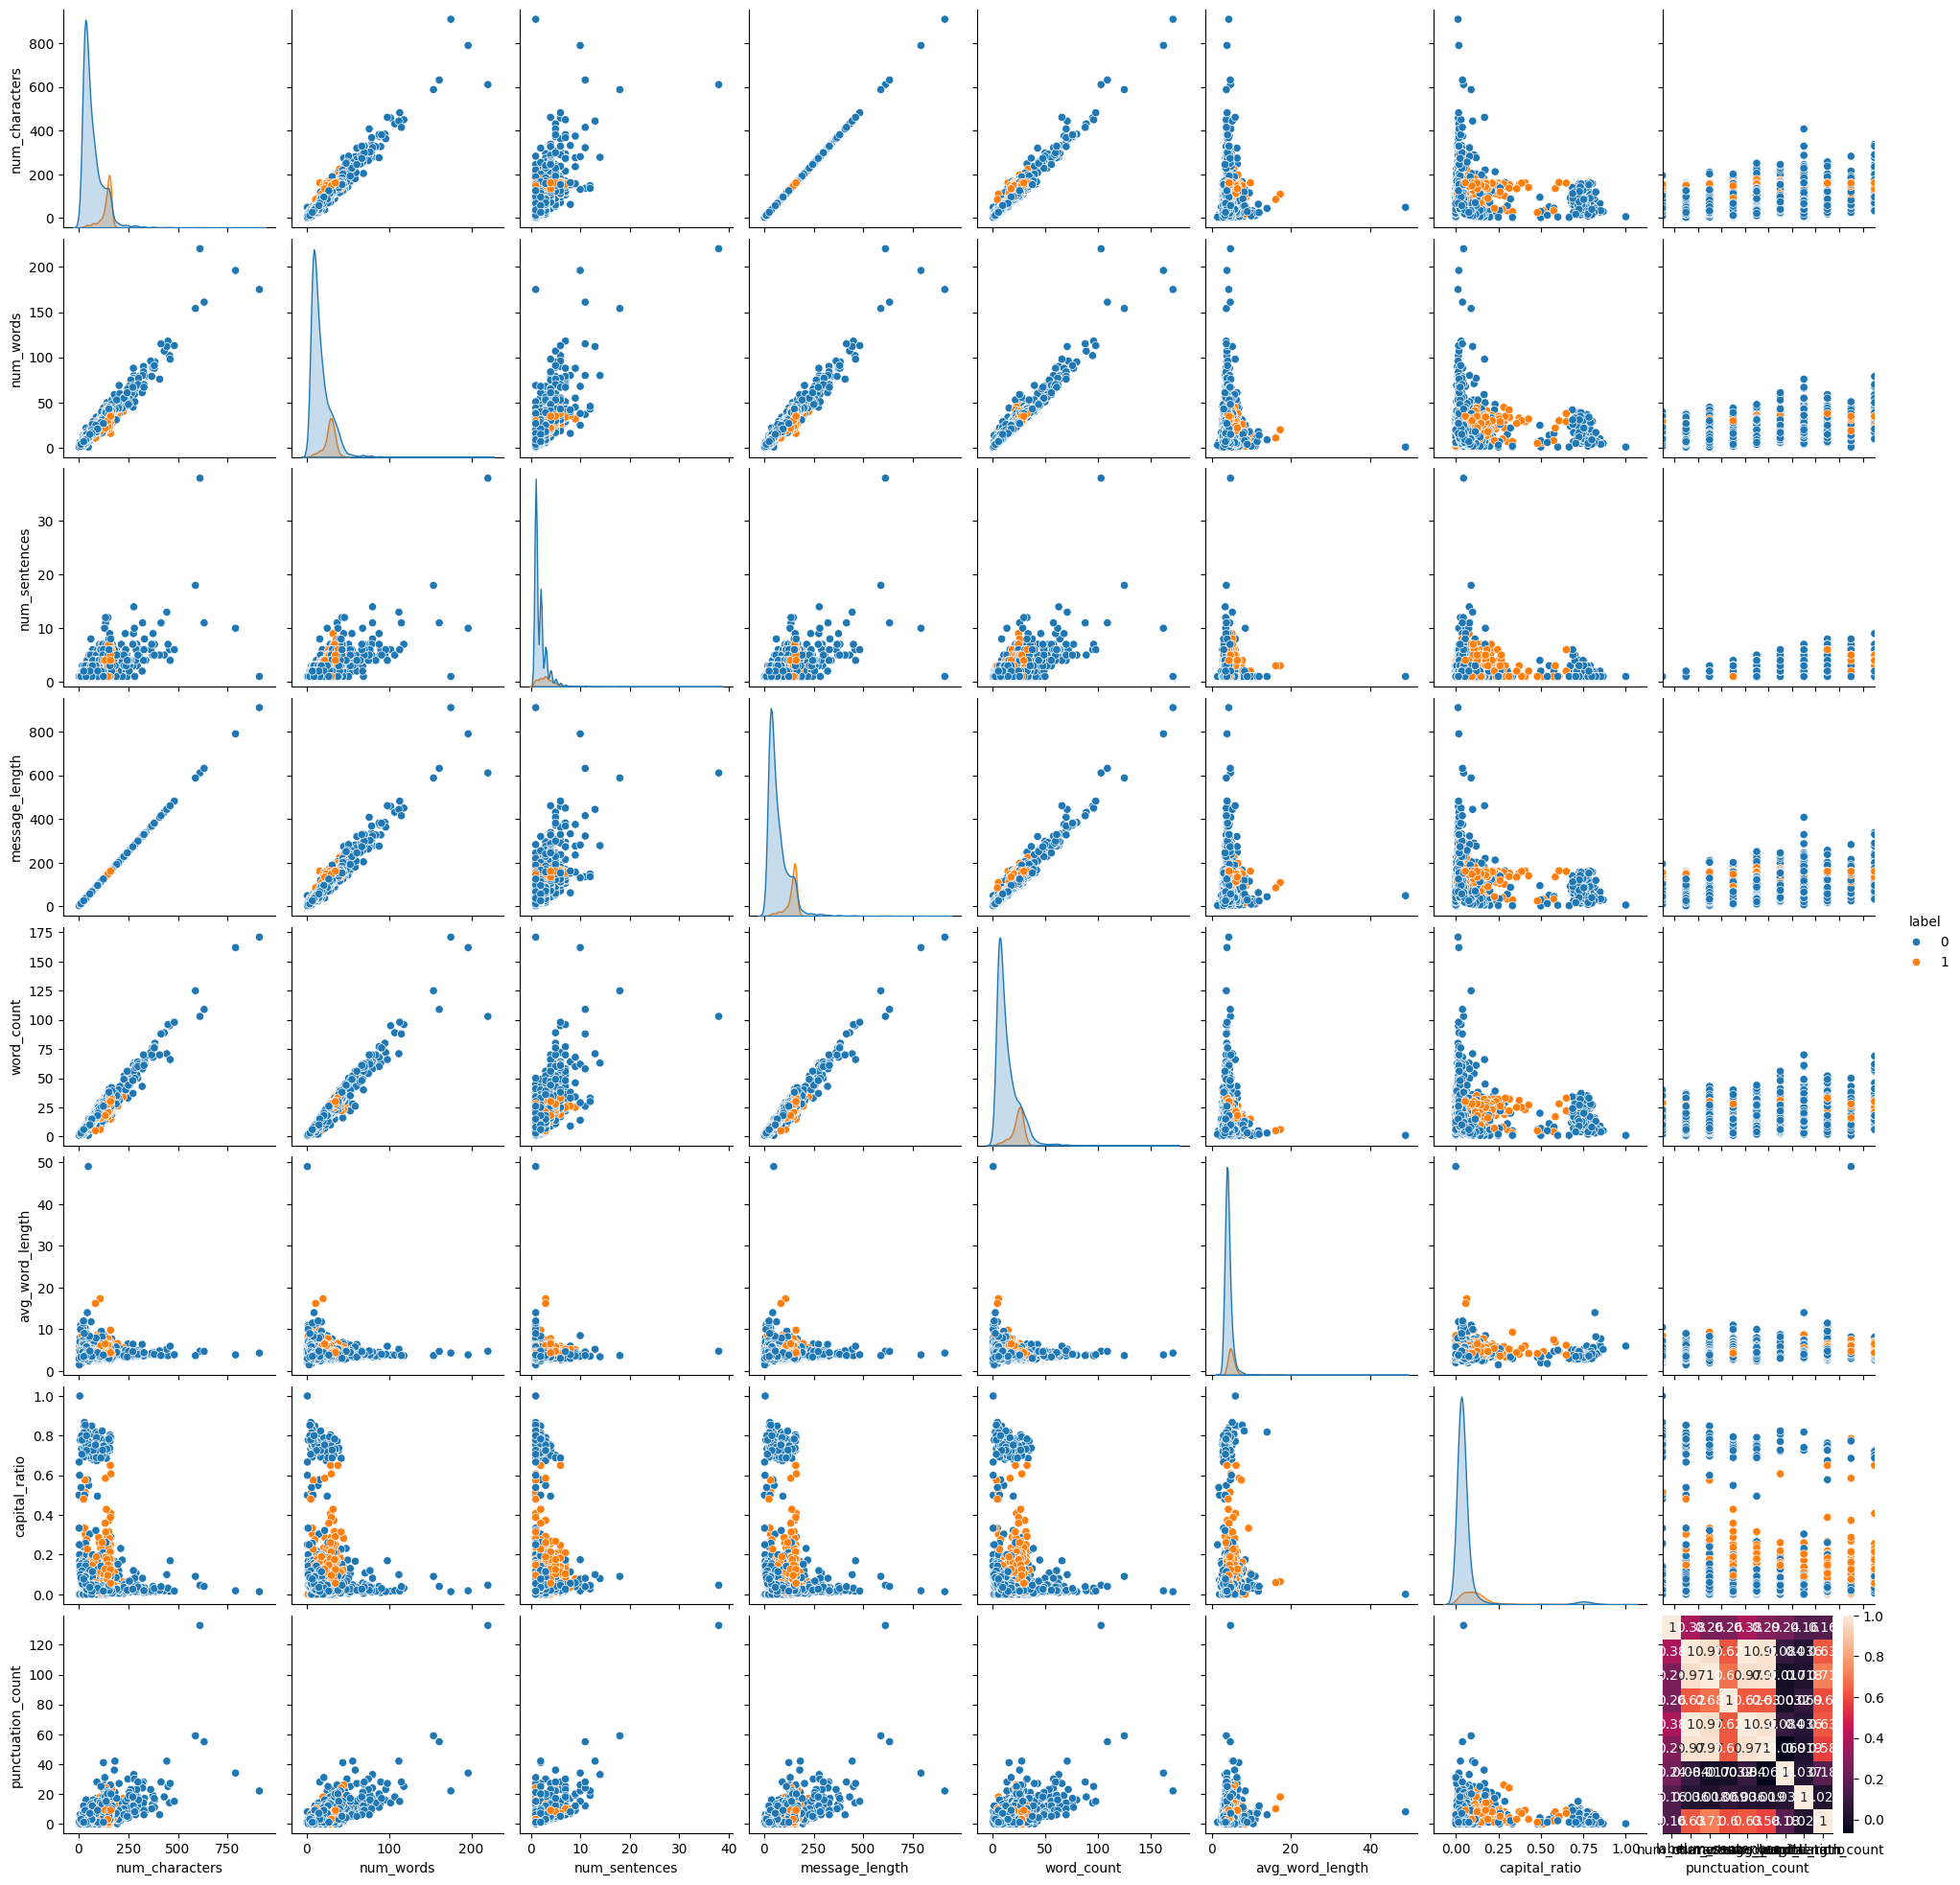

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 0]['num_characters'])
sns.histplot(df[df['label'] == 1]['num_characters'],color='red')

plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 0]['num_words'])
sns.histplot(df[df['label'] == 1]['num_words'],color='red')

sns.pairplot(df,hue='label')

# Calculate correlation only on numerical columns
sns.heatmap(df.select_dtypes(include=np.number).corr(),annot=True)

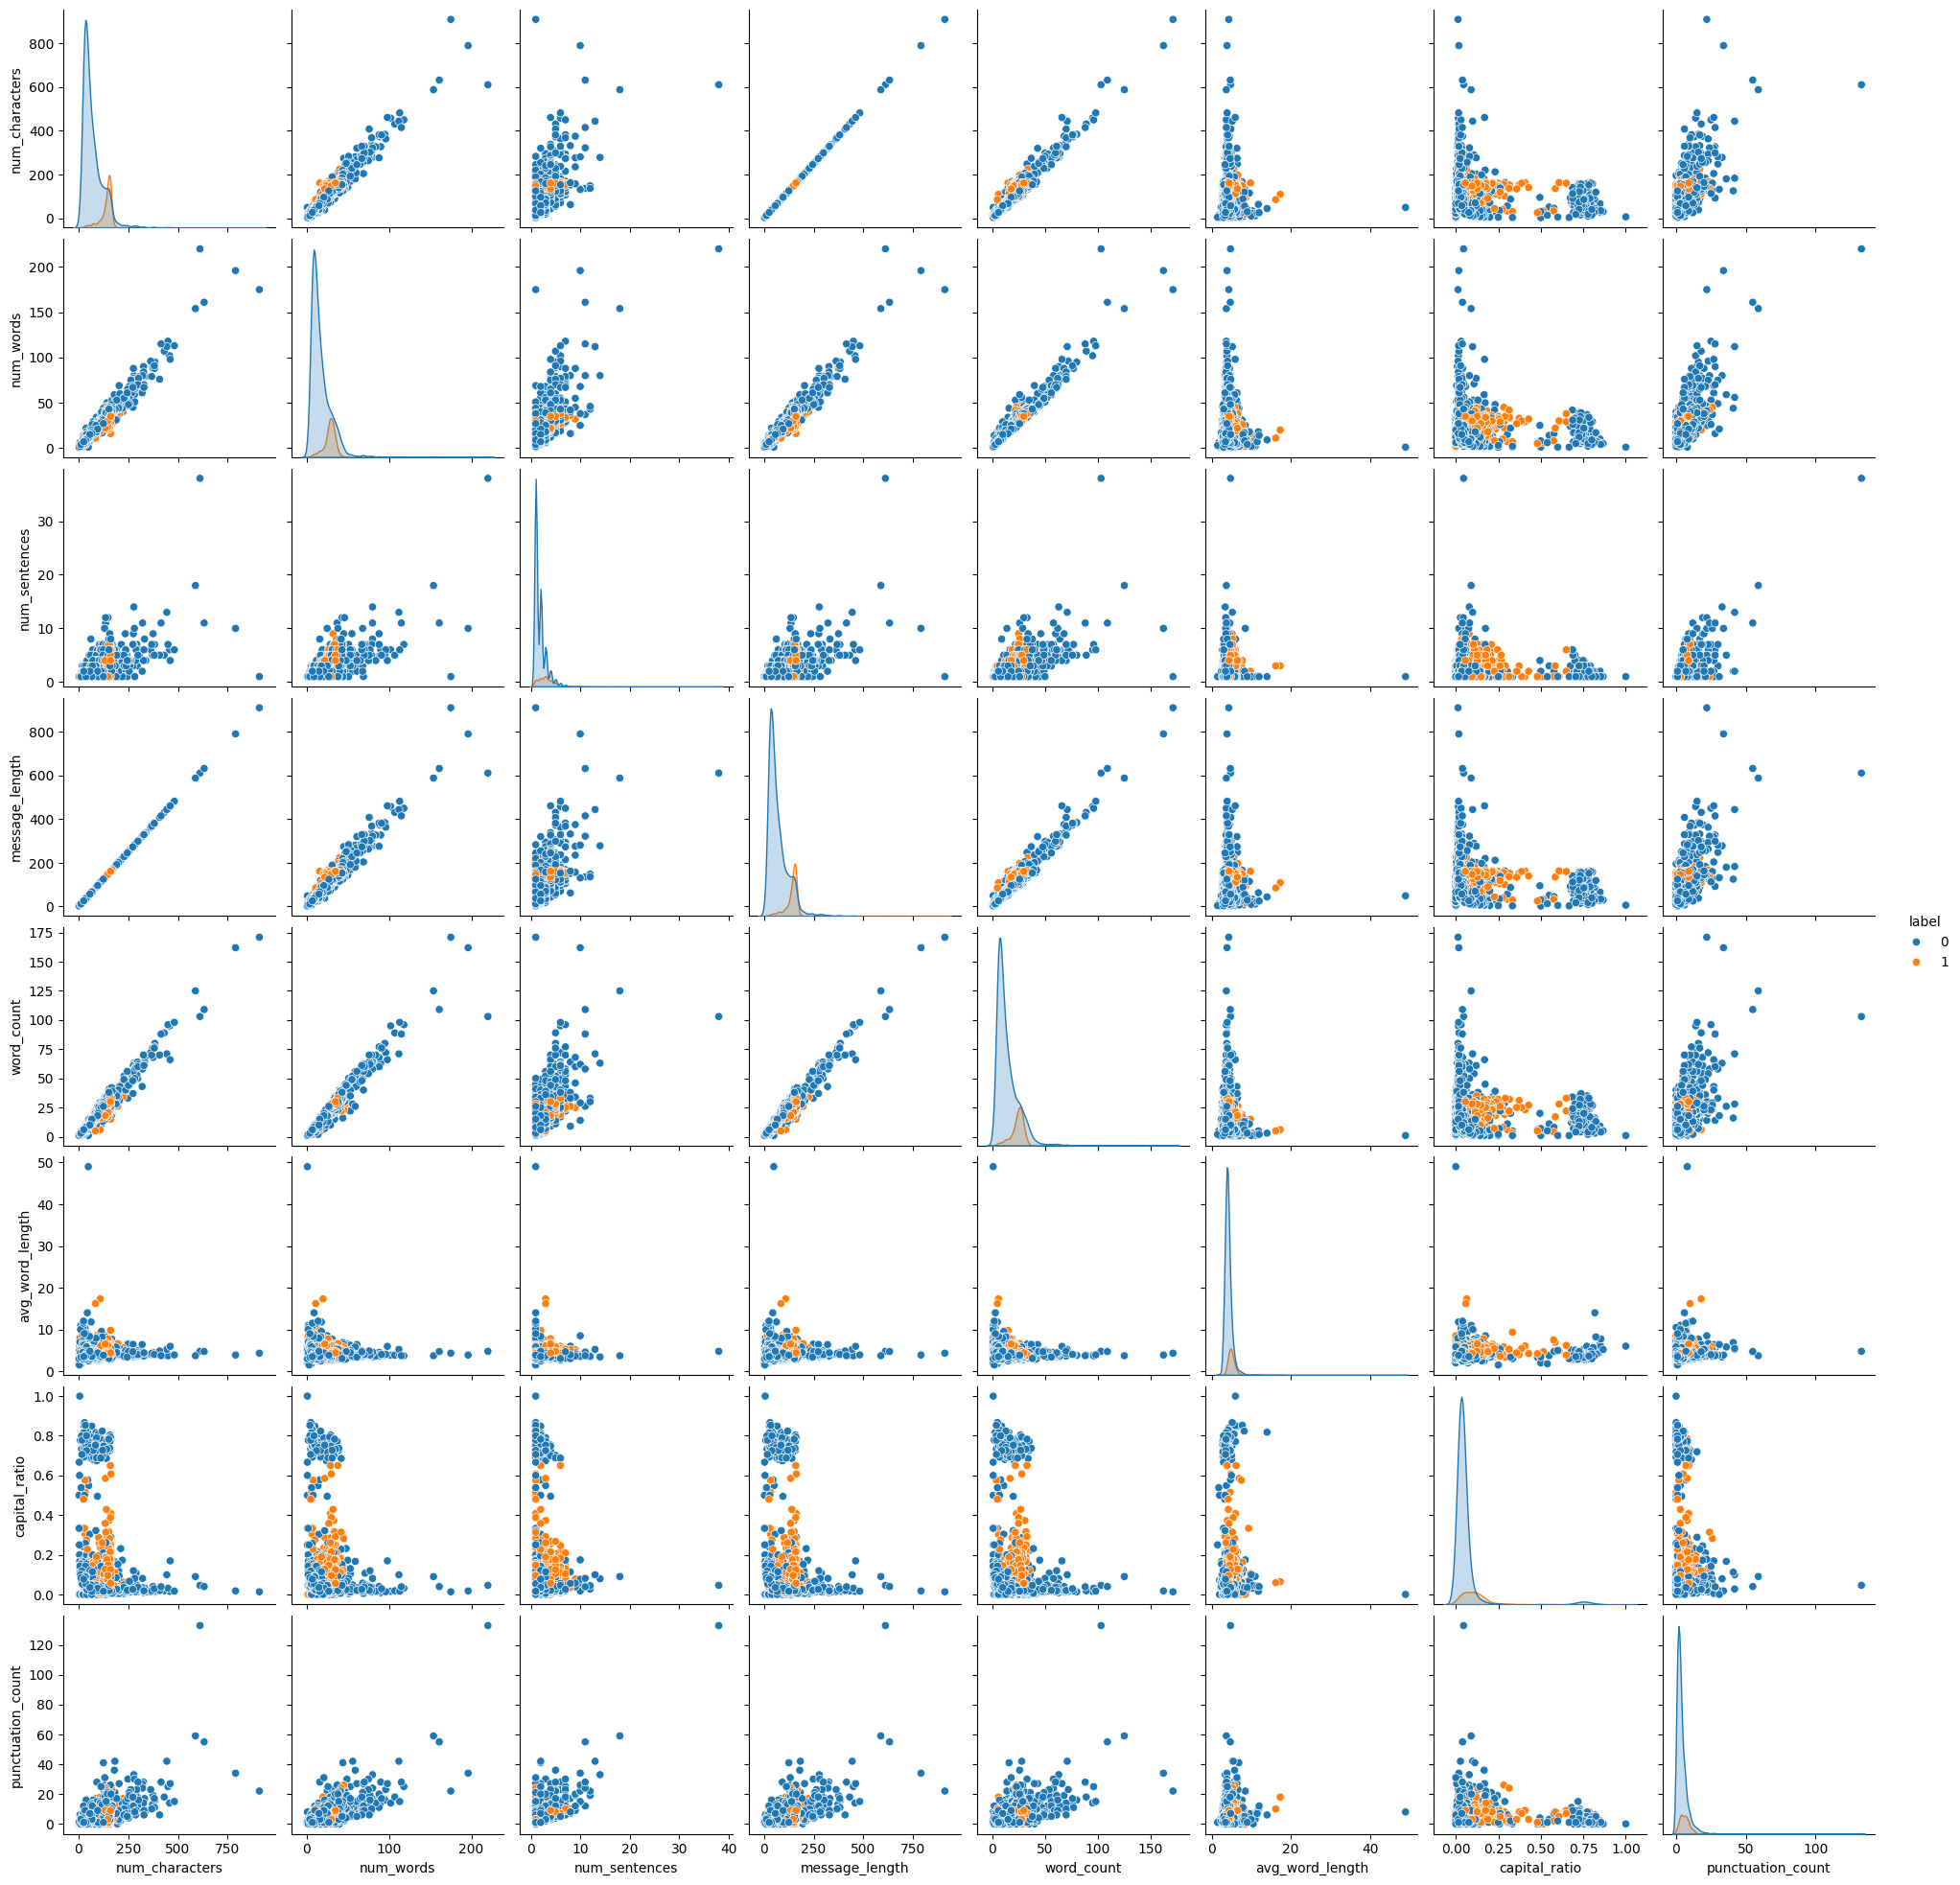

In [42]:
sns.pairplot(df,hue='label')

<Axes: >

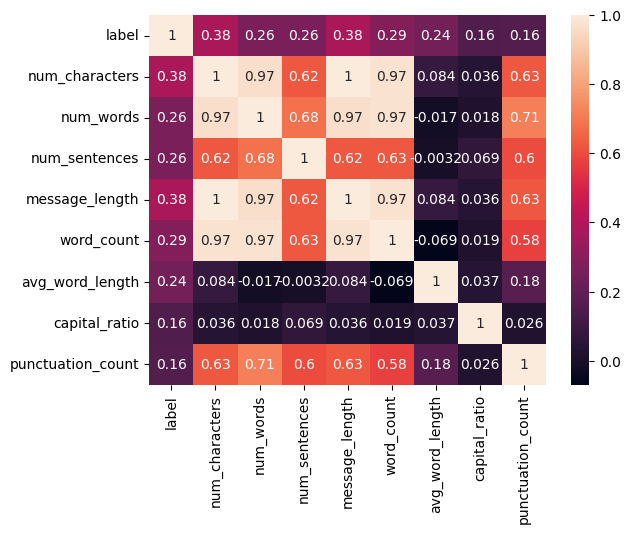

In [43]:
# Calculate correlation only on numerical columns
sns.heatmap(df.select_dtypes(include=np.number).corr(),annot=True)

3. Data Preprocessing

Lower case

Tokenization

Removing special characters

Removing stop words and punctuation

Stemming

In [9]:
import nltk
import string

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))


    return " ".join(y)

df['transformed_text'] = df['message'].apply(transform_text)

In [10]:
# Calculate features from transformed_text (after preprocessing)
df['num_characters'] = df['transformed_text'].apply(len)
df['num_words'] = df['transformed_text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['transformed_text'].apply(lambda x:len(nltk.sent_tokenize(x)))

df['message_length'] = df['transformed_text'].str.len()
df['word_count'] = df['transformed_text'].str.split().str.len()
df['avg_word_length'] = df['transformed_text'].str.split().apply(lambda x: np.mean([len(word) for word in x]) if x else 0)
df['capital_ratio'] = df['transformed_text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df['punctuation_count'] = df['transformed_text'].str.count(r'[^\w\s]')


# Basic statistics for the new features
print("\nFeature statistics after preprocessing:")
print(df[['num_characters','num_words','num_sentences','message_length', 'word_count', 'avg_word_length', 'capital_ratio', 'punctuation_count']].describe())


Feature statistics after preprocessing:
       num_characters    num_words  num_sentences  message_length  \
count     5169.000000  5169.000000    5169.000000     5169.000000   
mean        45.141227     8.772103       0.998259       45.141227   
std         34.514083     6.436092       0.041695       34.514083   
min          0.000000     0.000000       0.000000        0.000000   
25%         20.000000     4.000000       1.000000       20.000000   
50%         34.000000     7.000000       1.000000       34.000000   
75%         65.000000    12.000000       1.000000       65.000000   
max        389.000000    74.000000       1.000000      389.000000   

        word_count  avg_word_length  capital_ratio  punctuation_count  
count  5169.000000      5169.000000         5169.0             5169.0  
mean      8.772103         4.254103            0.0                0.0  
std       6.436092         0.905668            0.0                0.0  
min       0.000000         0.000000            0.

9939


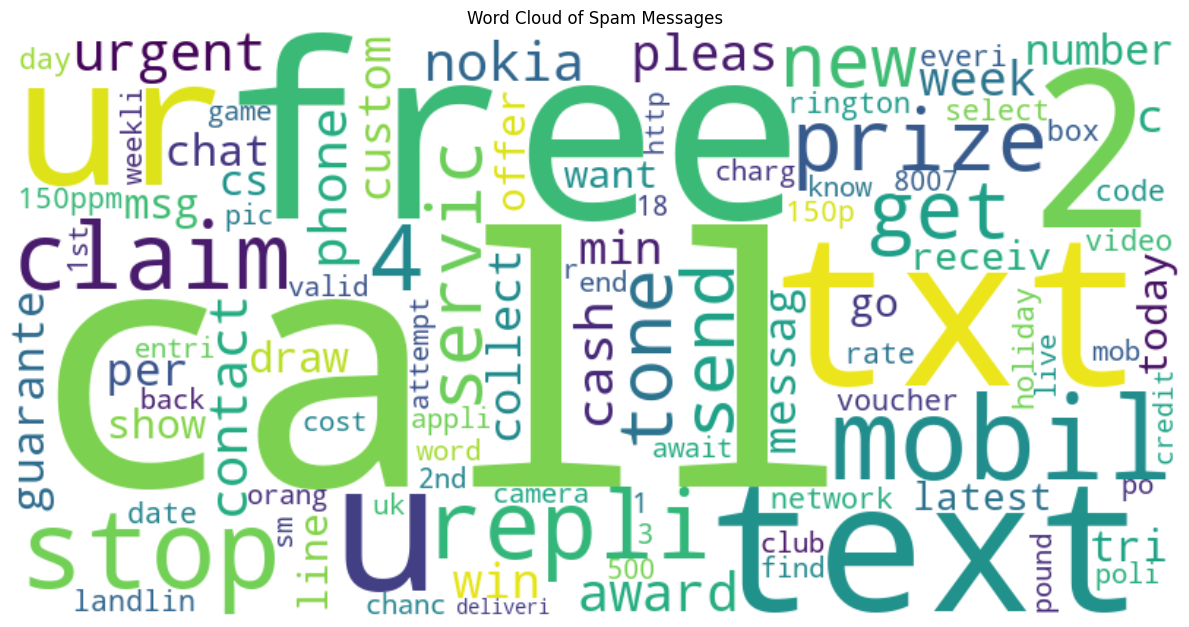

In [11]:
spam_corpus = []
for msg in df[df['label'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

print(len(spam_corpus))

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# First, create the word frequency counter from your spam_corpus
word_counts = Counter(spam_corpus)

# Now create the word cloud
wordcloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     max_words=100,
                     colormap='viridis').generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Spam Messages')
plt.tight_layout()
plt.show()

In [13]:
#Model Building
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
#vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)


X = tfidf.fit_transform(df['transformed_text']).toarray()
Y = df['label'].values
X.shape
Y.shape

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=2)

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_train, y_train)
y_pred_tfidf = mnb_tfidf.predict(X_test)

print("\nTfidfVectorizer Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf)}")
print(f"Precision: {precision_score(y_test, y_pred_tfidf)}")


TfidfVectorizer Results:
Accuracy: 0.9709864603481625
Precision: 1.0


In [14]:
# Using CountVectorizer instead of TF-IDF
# CountVectorizer counts word frequencies (bag-of-words)
# Similar usage to TF-IDF, but simpler - just counts occurrences

# You can configure CountVectorizer with parameters:
cv = CountVectorizer(max_features=3000)  # Limit to top 3000 features

# Transform text to numerical features
X_cv = cv.fit_transform(df['transformed_text']).toarray()
Y = df['label'].values

print("CountVectorizer shape:", X_cv.shape)
print("Label shape:", Y.shape)

# Compare: CountVectorizer vs TF-IDF
# - CountVectorizer: Simple word count (how many times each word appears)
# - TF-IDF: Weighted score (adjusts for word frequency across all documents)
# 
# Example: A common word like "the" appears in many messages
# - CountVectorizer: Might give it high value
# - TF-IDF: Will give it lower weight because it's common everywhere

# You can use X_cv for training models just like X (from TF-IDF)
# Let's train a model with CountVectorizer to compare:

X_train_cv, X_test_cv, y_train, y_test = train_test_split(X_cv, Y, test_size=0.2, random_state=2)

mnb_cv = MultinomialNB()
mnb_cv.fit(X_train_cv, y_train)
y_pred_cv = mnb_cv.predict(X_test_cv)

print("\nCountVectorizer Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cv)}")
print(f"Precision: {precision_score(y_test, y_pred_cv)}")


CountVectorizer shape: (5169, 3000)
Label shape: (5169,)

CountVectorizer Results:
Accuracy: 0.9738878143133463
Precision: 0.8992805755395683


In [49]:
#GaussianNB
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(f' accuracy score: {accuracy_score(y_test,y_pred1)}')
print(f' confusion matrix: {confusion_matrix(y_test,y_pred1)}')
print(f' precision score: {precision_score(y_test,y_pred1)}')


 accuracy score: 0.8733075435203095
 confusion matrix: [[790 106]
 [ 25 113]]
 precision score: 0.5159817351598174


In [50]:
#MultinomialNB
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(f'accuracy_score: {accuracy_score(y_test,y_pred2)}')
print(f'confusion_matrix: {confusion_matrix(y_test,y_pred2)}')
print(f'precision_score: {precision_score(y_test,y_pred2)}')

accuracy_score: 0.9709864603481625
confusion_matrix: [[896   0]
 [ 30 108]]
precision_score: 1.0


In [51]:
bnb.fit(X_train,y_train)
y_pred2 = bnb.predict(X_test)
print(f' accuracy score: {accuracy_score(y_test,y_pred2)}')
print(f' confusion matrix: {confusion_matrix(y_test,y_pred2)}')
print(f' precision score: {precision_score(y_test,y_pred2)}')

 accuracy score: 0.9835589941972921
 confusion matrix: [[895   1]
 [ 16 122]]
 precision score: 0.991869918699187


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [53]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)

    return accuracy,precision

accuracy_scores = []
precision_scores = []

for mod in clfs:
    accuracy,precision = train_classifier(clfs[mod],X_train,y_train,X_test,y_test)
    print(f'{mod} Accuracy is {accuracy} and Precision is {precision}')
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

SVC Accuracy is 0.9758220502901354 and Precision is 0.9747899159663865
KN Accuracy is 0.9052224371373307 and Precision is 1.0
NB Accuracy is 0.9709864603481625 and Precision is 1.0
DT Accuracy is 0.9332688588007737 and Precision is 0.8415841584158416
LR Accuracy is 0.9564796905222437 and Precision is 0.9696969696969697
RF Accuracy is 0.97678916827853 and Precision is 0.975
AdaBoost Accuracy is 0.9235976789168279 and Precision is 0.8390804597701149
BgC Accuracy is 0.9593810444874274 and Precision is 0.8692307692307693
ETC Accuracy is 0.9777562862669246 and Precision is 0.967479674796748
GBDT Accuracy is 0.9506769825918762 and Precision is 0.9306930693069307
xgb Accuracy is 0.9709864603481625 and Precision is 0.95


In [54]:
#Analysing performance of different AI models
performance_df = pd.DataFrame({'Algorithm': clfs.keys(),'Accuracy' : accuracy_scores, 'Precision' : precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.970986,1.000000
5,RF,0.976789,0.975000
0,SVC,0.975822,0.974790
4,LR,0.956480,0.969697
8,ETC,0.977756,0.967480
10,xgb,0.970986,0.950000
9,GBDT,0.950677,0.930693
7,BgC,0.959381,0.869231
3,DT,0.933269,0.841584


In [55]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.905222
1,NB,Accuracy,0.970986
2,RF,Accuracy,0.976789
3,SVC,Accuracy,0.975822
4,LR,Accuracy,0.956480
5,ETC,Accuracy,0.977756
6,xgb,Accuracy,0.970986
7,GBDT,Accuracy,0.950677
8,BgC,Accuracy,0.959381
9,DT,Accuracy,0.933269


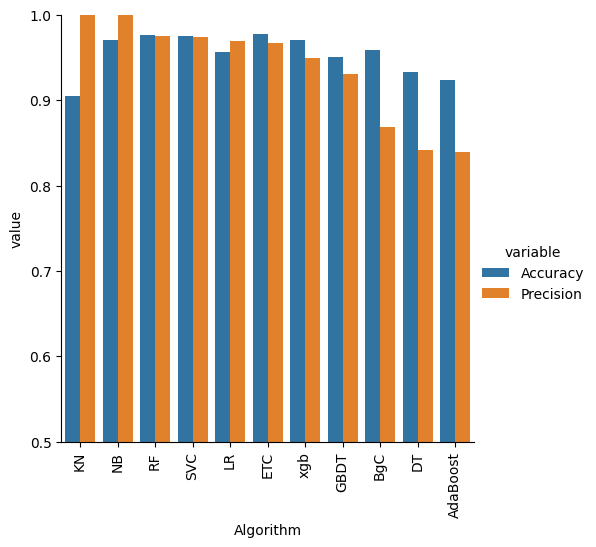

In [56]:
sns.catplot(x = 'Algorithm', y='value',
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [24]:
#Deep Learning Model with NLP 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000         # Size of vocabulary
max_len = 100            # Max length for each message

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['message'])  
sequences = tokenizer.texts_to_sequences(df['message'])
x = pad_sequences(sequences, maxlen=max_len)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM

model = Sequential([
    Embedding(input_dim=max_words, output_dim=32),  # Removed deprecated input_length
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),  # Optional: extra hidden layer
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer MUST be last
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, 
          class_weight=class_weight_dict, callbacks=[early_stop])

results = model.evaluate(X_test, y_test)
print(f"Test loss, accuracy: {results}")

preds = model.predict(X_test)

for threshold in [0.3, 0.4, 0.5, 0.6]:
    preds_class = (preds > threshold).astype(int)
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    print(f"\nThreshold: {threshold}")
    print(f"Precision: {precision_score(y_test, preds_class)}")
    print(f"Recall: {recall_score(y_test, preds_class)}")
    print(f"F1-Score: {f1_score(y_test, preds_class)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, preds_class)}")


Class weights: {0: 0.5700303280948442, 1: 4.06988188976378}


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - Precision: 0.4230 - Recall: 0.7627 - accuracy: 0.8379 - loss: 0.4541 - val_Precision: 0.8974 - val_Recall: 0.9722 - val_accuracy: 0.9879 - val_loss: 0.0976
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - Precision: 0.9143 - Recall: 0.9492 - accuracy: 0.9823 - loss: 0.1266 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.9758 - val_loss: 0.0881
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - Precision: 0.9385 - Recall: 0.9703 - accuracy: 0.9882 - loss: 0.0648 - val_Precision: 0.8974 - val_Recall: 0.9722 - val_accuracy: 0.9879 - val_loss: 0.0358
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - Precision: 0.9709 - Recall: 0.9894 - accuracy: 0.9949 - loss: 0.0346 - val_Precision: 0.9211 - val_Recall: 0.9722 - val_accuracy: 0.9903 - val_loss: 0.0187
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - Precision: 0.9894 - Recall: 0.9915 - accuracy: 0.9976 - loss: 0.0268 - val_Precision: 0.8889 - val_R